[![Notebook Tutorial](__code/__all/notebook_tutorial.png)](https://neutronimaging.ornl.gov/tutorial/notebooks/timepix3_from_event_to_hito_nexus)

<img src='__docs/__all/notebook_rules.png' />

# Select Your IPTS 

In [1]:
from __code import system
from __code.timepix3_from_event_to_histo_nexus.timepix3_from_event_to_histo_nexus import Timepix3FromEventToHistoNexus

import h5py
import numpy as np

system.System.select_working_dir(facility='SNS', instrument='SNAP')
from __code.__all import custom_style
custom_style.style()

import matplotlib.pyplot as plt
%matplotlib notebook

** Using Debugging Mode! **


# Select Event NeXus

In [2]:
# DEBUGGING ONLY

# He3
#working_dir = "/Users/j35/SNS/SNAP/IPTS-30008/nexus/"
#working_dir = "/Volumes/JeanHardDrive/SNS/SNAP/IPTS-30008/nexus/"
# nexus_filename = 'SNAP_58700.nxs.h5'

# # MCP
working_dir = "/Users/j35/SNS/SNAP/IPTS-30008/nexus/"
# nexus_filename = "run58704_events.h5"
nexus_filename = "run58744_events.h5"

o_event = Timepix3FromEventToHistoNexus(working_dir=system.System.get_working_dir())
#o_event = Timepix3EventNexus(working_dir=working_dir)

import os
nexus_file = os.path.join(working_dir, nexus_filename)
assert os.path.exists(nexus_file)

o_event.display_tree_structure(nexus_file)


#o_event.load_event_nexus(nexus_file_name=nexus_file)
# o_event.rebin_and_display_data()



 events
    │
    ├── NHits (1119190,)
    ├── tof_ns (1119190,)
    ├── x (1119190,)
    └── y (1119190,)


# Manually loading the data

In [3]:
with h5py.File(nexus_file, 'r') as nxs:
    o_event.x_array = np.array(nxs['events']['x'])
    o_event.y_array = np.array(nxs['events']['y'])
    o_event.tof_array = np.array(nxs['events']['tof_ns'])

# Some statistics 

In [4]:
o_event.display_infos()

# Define MCP detector size 

In [5]:
o_event.define_detector()

# Binning data (Zzz)

In [6]:
o_event.select_binning_parameter()

IntText(value=1000, description='Nbr of bins:')

IntSlider(value=50, description='% to use', min=1)

This may take some time, be patient!

In [7]:
o_event.bins()

# Display integrated stack 

<IPython.core.display.Javascript object>


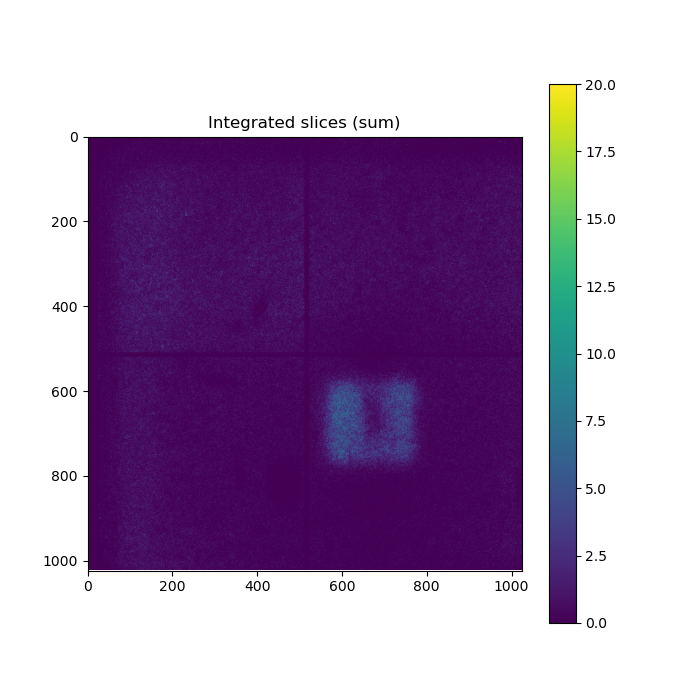

interactive(children=(IntSlider(value=0, description='vmin', max=20), IntSlider(value=20, description='vmax', …

In [8]:
o_event.display_integrated_stack()

# Display slices 

<IPython.core.display.Javascript object>


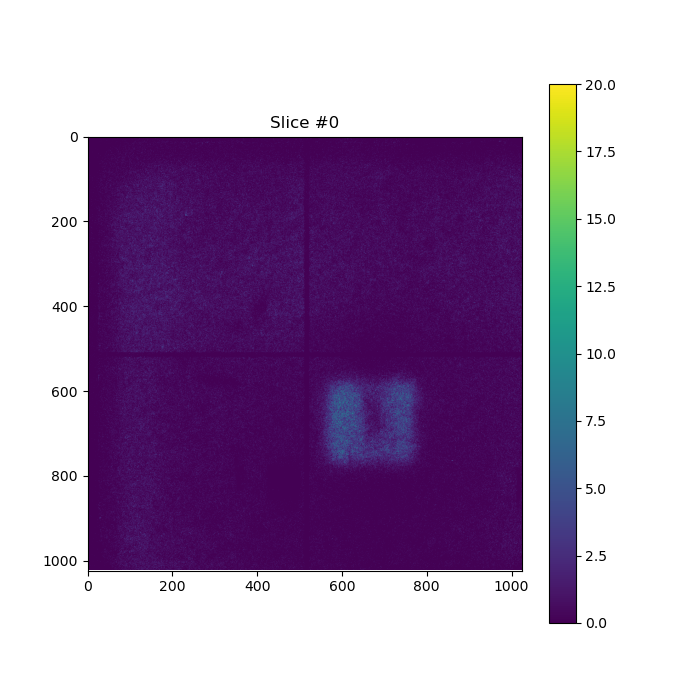

interactive(children=(IntSlider(value=0, description='index', max=1023), Output()), _dom_classes=('widget-inte…

In [9]:
o_event.display_slices()

# Export Histogram HDF5 

In [10]:
o_event.define_output_filename()

In [11]:
o_event.select_output_location()

AttributeError: 'Timepix3FromEventToHistoNexus' object has no attribute 'nbr_bin'

In [85]:
print(f"{np.max(o_event.y_array) =}")
print(f"{np.max(o_event.x_array) =}")

np.max(o_event.y_array) =6343.845456240579
np.max(o_event.x_array) =7414.84623732668


In [86]:
import numpy as np

working_limit = -1

tof_ns_array = o_event.tof_ns_array[0:working_limit]
x_array = o_event.x_array[0:working_limit]
y_array = o_event.y_array[0:working_limit]

nbr_bin = 10000

#indexes with NaN
index_nan = np.where(np.isnan(tof_ns_array))

# remove those x, y and tof_nx
tof_ns_array_cleaned = np.delete(tof_ns_array, index_nan)
x_array_cleaned = np.delete(x_array, index_nan)
y_array_cleaned = np.delete(y_array, index_nan)

histo_tof, bins_tof = np.histogram(tof_ns_array_cleaned, nbr_bin)

In [87]:
# going one by one and finding in which bin they belong

In [88]:
stack_images = np.zeros((nbr_bin, 1024, 1024))
np.shape(stack_images)

(10000, 1024, 1024)

In [89]:
for _index, _tof in enumerate(tof_ns_array):
    _array_location = np.where((bins_tof - _tof) < 0)
    try:
        _location = _array_location[0][-1]
    except IndexError:
        _location = 0
    x = round(x_array[_index])
    y = round(y_array[_index])
    if (x<0) or (y<0) or (x>1023) or (y>1023):
        continue
        
    stack_images[_location, y, x] += 1
#     print(f"{_location =}, {y =}, {x =}")
        

<IPython.core.display.Javascript object>


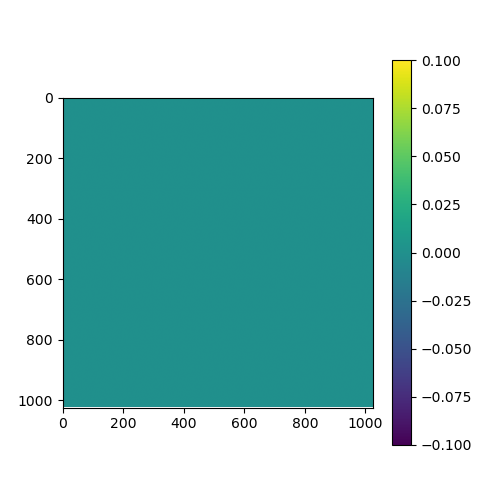

In [90]:
fig, ax = plt.subplots(figsize=(5,5),
                      nrows=1, ncols=1)
pt = ax.imshow(stack_images[100])
plt.colorbar(pt)

In [91]:
integration = np.sum(stack_images, axis=1)
integration = np.sum(integration, axis=1)

In [92]:
np.shape(integration)

(10000,)

<IPython.core.display.Javascript object>


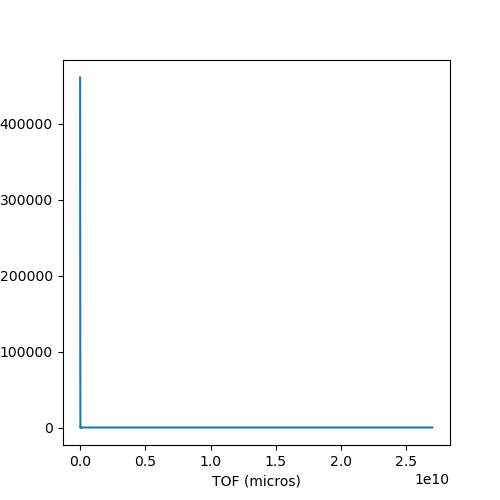

Text(0, 0.5, 'Mean counts of each bin')

In [93]:
fig1, ax1 = plt.subplots(figsize=(5,5),
                      nrows=1, ncols=1,
                        num=nexus_filename)
ax1.plot(bins_tof[:-1], integration)
ax1.set_xlabel("TOF (micros)")
ax1.set_ylabel("Mean counts of each bin")

# export the data inoto NeXus

In [94]:
working_dir = "/Users/j35/SNS/SNAP/IPTS-30008/nexus/"
nexus_filename = "run58744_histo.h5"
output_nexus_filename = os.path.join(working_dir, nexus_filename)

In [100]:
with h5py.File(output_nexus_filename, mode='w') as f:
    f.create_group('entry/histo')
    f.create_dataset('entry/histo/stack', data=stack_images)
    f.create_dataset('entry/histo/number_of_bins', data=nbr_bin)
    f.create_group('entry/infos')
    f.create_dataset('entry/infos/input_nexus_filename', data="run58744_events.h5")
